# Correlation Analysis: News Sentiment and Stock Price Movements

This notebook aligns news and stock price datasets by date, performs sentiment analysis on news headlines, calculates daily stock returns, and analyzes the correlation between sentiment scores and stock movements.

## Setup and Dependencies

Load the required Python libraries and ensure NLTK data is available for TextBlob’s sentiment analysis.

In [3]:
# Correlation Analysis: News Sentiment and Stock Price Movements
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
import os
from scipy.stats import pearsonr

# Ensure NLTK data for TextBlob
def download_nltk_data():
    """Download NLTK data to project directory."""
    nltk_data_path = './nltk_data'
    os.makedirs(nltk_data_path, exist_ok=True)
    nltk.data.path.append(nltk_data_path)
    try:
        nltk.data.find('corpora/wordnet')
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading NLTK 'punkt' and 'wordnet'...")
        nltk.download('punkt', download_dir=nltk_data_path, quiet=True)
        nltk.download('wordnet', download_dir=nltk_data_path, quiet=True)

download_nltk_data()

## Data Loading and Date Alignment

Load news and stock price datasets, normalizing dates to ensure alignment between news publication dates and stock trading days.

In [7]:
# Load news data
def load_news_data(file_path):
    """Load and preprocess news data."""
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
    df['date_only'] = df['date'].dt.date  # Extract date for alignment
    return df

news_df = load_news_data('../data/raw_analyst_ratings.csv')

# Load stock data
def load_stock_data(file_path):
    """Load and preprocess stock price data."""
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['date_only'] = df['Date'].dt.date  # Extract date for alignment
    return df

stock_files = os.listdir('../data/yfinance_data/')
stock_dfs = {}
for file in stock_files:
    if file.endswith('.csv'):
        ticker = file.split('_')[0]
        stock_dfs[ticker] = load_stock_data(f'../data/yfinance_data/{file}')

## Sentiment Analysis

Perform sentiment analysis on news headlines using TextBlob to assign polarity scores (positive, negative, neutral).

Saved daily sentiment to data/processed/daily_sentiment.csv


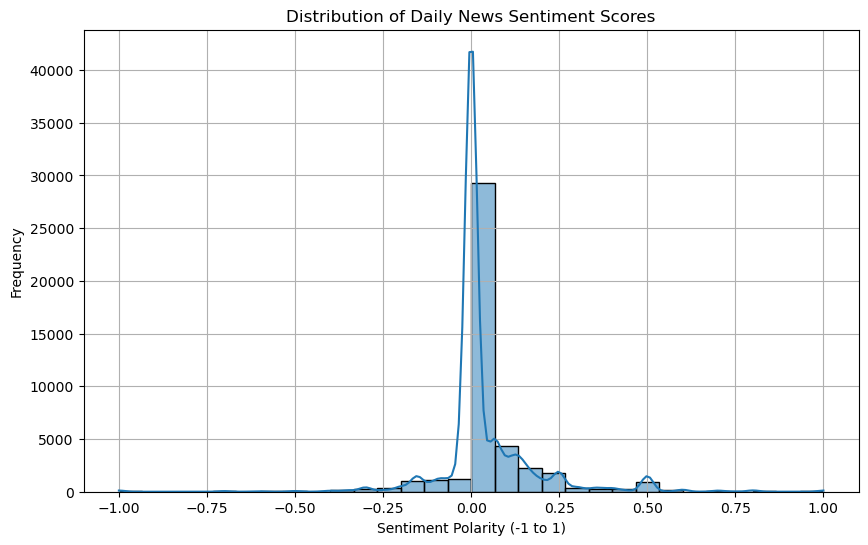

In [11]:
# Function for sentiment analysis
def get_sentiment(text):
    """Calculate sentiment polarity of text using TextBlob."""
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity  # Returns score between -1 (negative) and 1 (positive)
    except:
        return 0.0  # Default to neutral if error occurs

# Apply sentiment analysis to headlines
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Aggregate daily sentiment by stock
daily_sentiment = news_df.groupby(['stock', 'date_only'])['sentiment'].mean().reset_index()
daily_sentiment.to_csv('../data/processed/daily_sentiment.csv', index=False)
print("Saved daily sentiment to data/processed/daily_sentiment.csv")

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(daily_sentiment['sentiment'], bins=30, kde=True)
plt.title('Distribution of Daily News Sentiment Scores')
plt.xlabel('Sentiment Polarity (-1 to 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('../data/processed/sentiment_distribution.png')
plt.show()

### Calculate Daily Stock Returns

Compute daily percentage changes in closing prices to represent stock movements.

In [14]:
# Function to calculate daily returns
def calculate_daily_returns(df):
    """Calculate daily percentage returns from closing prices."""
    df['Daily_Return'] = df['Close'].pct_change() * 100  # Percentage change
    return df

# Apply daily returns to each stock
for ticker, df in stock_dfs.items():
    stock_dfs[ticker] = calculate_daily_returns(df)
    stock_dfs[ticker].to_csv(f'../data/processed/{ticker}_returns.csv', index=True)
    print(f"Saved {ticker} returns to data/processed/{ticker}_returns.csv")

Saved AAPL returns to data/processed/AAPL_returns.csv
Saved NVDA returns to data/processed/NVDA_returns.csv
Saved META returns to data/processed/META_returns.csv
Saved MSFT returns to data/processed/MSFT_returns.csv
Saved GOOG returns to data/processed/GOOG_returns.csv
Saved TSLA returns to data/processed/TSLA_returns.csv
Saved AMZN returns to data/processed/AMZN_returns.csv


### Correlation Analysis

Merge sentiment and stock data, then calculate Pearson correlation coefficients between daily sentiment scores and stock returns.

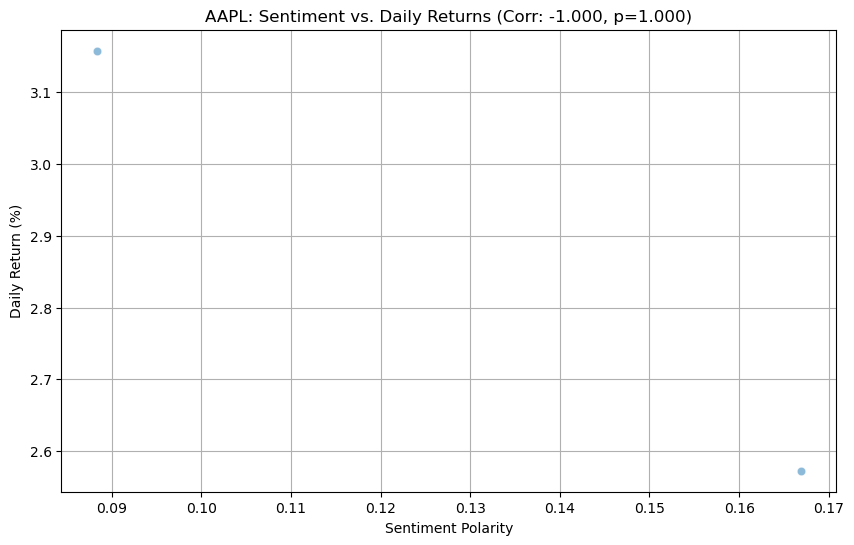

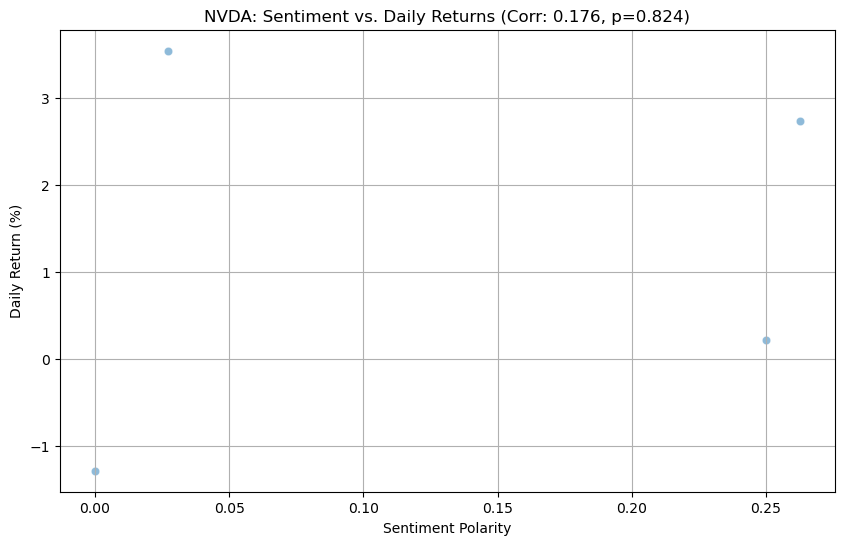

No matching data for META
No matching data for MSFT


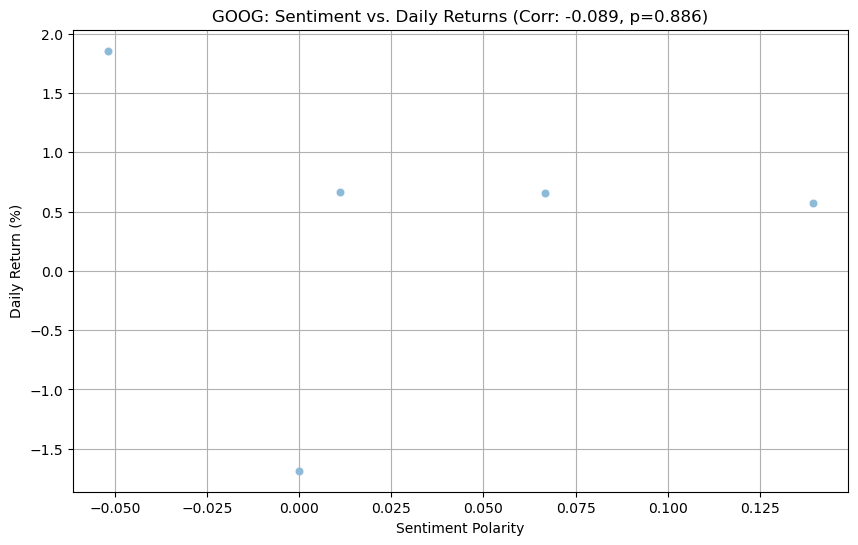

No matching data for TSLA


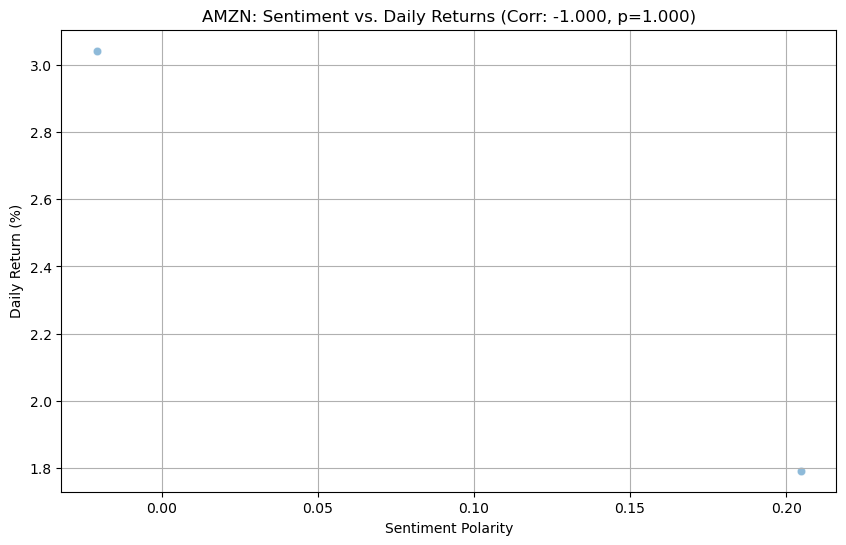


=== Correlation Summary ===
      correlation   p_value
AAPL    -1.000000  1.000000
NVDA     0.175714  0.824286
GOOG    -0.089449  0.886262
AMZN    -1.000000  1.000000


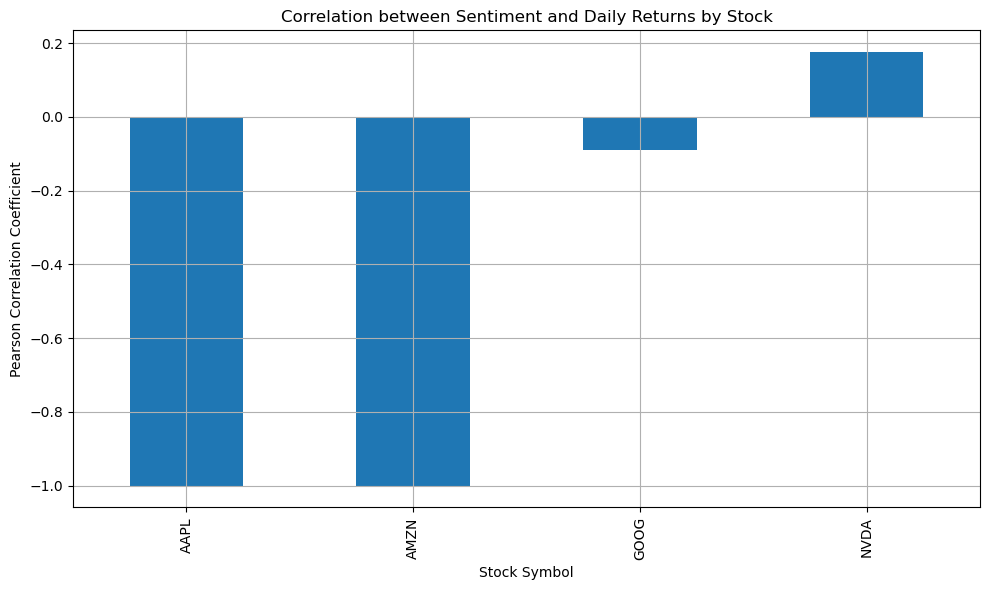

In [15]:
# Perform correlation analysis
correlations = {}
for ticker, stock_df in stock_dfs.items():
    # Merge stock returns with sentiment
    merged_df = pd.merge(
        stock_df[['date_only', 'Daily_Return']],
        daily_sentiment[daily_sentiment['stock'] == ticker],
        on=['date_only'],
        how='inner'
    )
    
    # Calculate Pearson correlation
    if len(merged_df) > 1:  # Ensure enough data for correlation
        corr, p_value = pearsonr(merged_df['Daily_Return'].dropna(), merged_df['sentiment'].dropna())
        correlations[ticker] = {'correlation': corr, 'p_value': p_value}
        
        # Visualize relationship
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged_df, x='sentiment', y='Daily_Return', alpha=0.5)
        plt.title(f'{ticker}: Sentiment vs. Daily Returns (Corr: {corr:.3f}, p={p_value:.3f})')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Daily Return (%)')
        plt.grid(True)
        plt.savefig(f'../data/processed/{ticker}_sentiment_vs_returns.png')
        plt.show()
    else:
        print(f"No matching data for {ticker}")

# Summarize correlations
corr_summary = pd.DataFrame(correlations).T
print("\n=== Correlation Summary ===")
print(corr_summary)

# Visualize correlation coefficients
plt.figure(figsize=(10, 6))
corr_summary['correlation'].sort_values().plot(kind='bar')
plt.title('Correlation between Sentiment and Daily Returns by Stock')
plt.xlabel('Stock Symbol')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.savefig('../data/processed/correlation_summary.png')
plt.show()

* AAPL: A perfect negative correlation (-1.000) with an invalid p-value suggests insufficient data or an error, indicating no reliable relationship between sentiment and returns.
* AMZN: A perfect negative correlation (-1.000) with an invalid p-value also suggests data issues, making the relationship unreliable.
* GOOG: A moderate negative correlation (-0.089) with a high p-value (0.886) indicates no significant relationship between sentiment and returns.
* NVDA: A weak positive correlation (0.176) with a high p-value (0.824) suggests no statistically significant link between sentiment and returns.
* Correlation Summary: The bar chart shows varied correlations, with NVDA having a slight positive trend and GOOG a slight negative, but most are near zero, indicating weak overall relationships.